In [1]:
from cryosparc.tools import CryoSPARC
import json
import numpy as np
import pandas as pd
import plotnine
from plotnine import ggplot, aes
with open('/u/rposert/instance-info.json', 'r') as f:
    instance_info = json.load(f)

cs = CryoSPARC(**instance_info)
assert cs.test_connection()

project_number = "P312"
workspace_number = "W8"
job_number = "J139"

project = cs.find_project(project_number)
job = project.find_job(job_number)
particles = job.load_output("particles")


Connection succeeded to CryoSPARC command_core at http://cryoem0.sbi:40002
Connection succeeded to CryoSPARC command_vis at http://cryoem0.sbi:40003
Connection succeeded to CryoSPARC command_rtp at http://cryoem0.sbi:40005


In [2]:
print(particles.fields())

['uid', 'ctf/type', 'ctf/exp_group_id', 'ctf/accel_kv', 'ctf/cs_mm', 'ctf/amp_contrast', 'ctf/df1_A', 'ctf/df2_A', 'ctf/df_angle_rad', 'ctf/phase_shift_rad', 'ctf/scale', 'ctf/scale_const', 'ctf/shift_A', 'ctf/tilt_A', 'ctf/trefoil_A', 'ctf/tetra_A', 'ctf/anisomag', 'ctf/bfactor', 'blob/path', 'blob/idx', 'blob/shape', 'blob/psize_A', 'blob/sign', 'blob/import_sig', 'alignments3D/split', 'alignments3D/shift', 'alignments3D/pose', 'alignments3D/psize_A', 'alignments3D/error', 'alignments3D/error_min', 'alignments3D/resid_pow', 'alignments3D/slice_pow', 'alignments3D/image_pow', 'alignments3D/cross_cor', 'alignments3D/alpha', 'alignments3D/alpha_min', 'alignments3D/weight', 'alignments3D/pose_ess', 'alignments3D/shift_ess', 'alignments3D/class_posterior', 'alignments3D/class', 'alignments3D/class_ess', 'alignments3D/fulcrum', 'alignments3D/object_pose', 'alignments3D/object_shift', 'alignments3D/local_pose', 'alignments3D/local_shift', 'alignments2D/split', 'alignments2D/shift', 'alignme

In [8]:
# this step is slow for large particle numbers
df = pd.DataFrame({
    'micrograph': particles['location/micrograph_uid'],
    'position_x': particles['location/center_x_frac'],
    'position_y': particles['location/center_y_frac'],
    'defocus': np.mean([particles['ctf/df1_A'], particles['ctf/df2_A']], axis = 0)
})

In [9]:
print(df)

                 micrograph  position_x  position_y       defocus
0       8277146426901187602    0.362963    0.473146  17009.859375
1       8277146426901187602    0.829630    0.741688  17072.503906
2       8277146426901187602    0.762963    0.391304  16968.445312
3       8277146426901187602    0.706173    0.117647  16891.902344
4       8277146426901187602    0.461728    0.613811  17129.972656
...                     ...         ...         ...           ...
397665  2556086873340501418    0.943210    0.606138  11895.223633
397666  2556086873340501418    0.335802    0.884910  11888.976562
397667  2556086873340501418    0.725926    0.368286  12003.735352
397668  2556086873340501418    0.479012    0.322251  12042.787109
397669  2556086873340501418    0.780247    0.327366  11852.354492

[397670 rows x 4 columns]


In [16]:
mean_defocus_per_mic = df[['micrograph', 'defocus']].groupby('micrograph').aggregate(np.mean)


/tmp/ipykernel_420385/646987695.py:1: FutureWarning: The provided callable <function mean at 0x7f5b3874ed40> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


In [22]:
df = df.join(
    mean_defocus_per_mic,
    'micrograph',
    rsuffix='_mean'
)

df['defocus_diff'] = df['defocus'] - df['defocus_mean']

In [26]:
micrographs = list(set(df['micrograph']))

In [51]:

def plot_single_mic(mic_index):
    filtered = df[df['micrograph'] == micrographs[mic_index]]
    limit = max(np.abs(filtered['defocus_diff']))
    return (
        ggplot(filtered, aes('position_x', 'position_y'))
        + plotnine.geom_point(aes(fill = 'defocus_diff'), size = 4)
        + plotnine.scale_fill_distiller(type = 'div', palette = 'PRGn', limits = [-limit, limit])
        + plotnine.labs(
            x = 'Micrograph Position X (fractional)',
            y = 'Micrograph Position Y (fractional)',
            fill = 'Difference from\nMean Defocus (\u212b)\n',
            title = f"Micrograph UID {micrographs[mic_index]}"
        )
    )

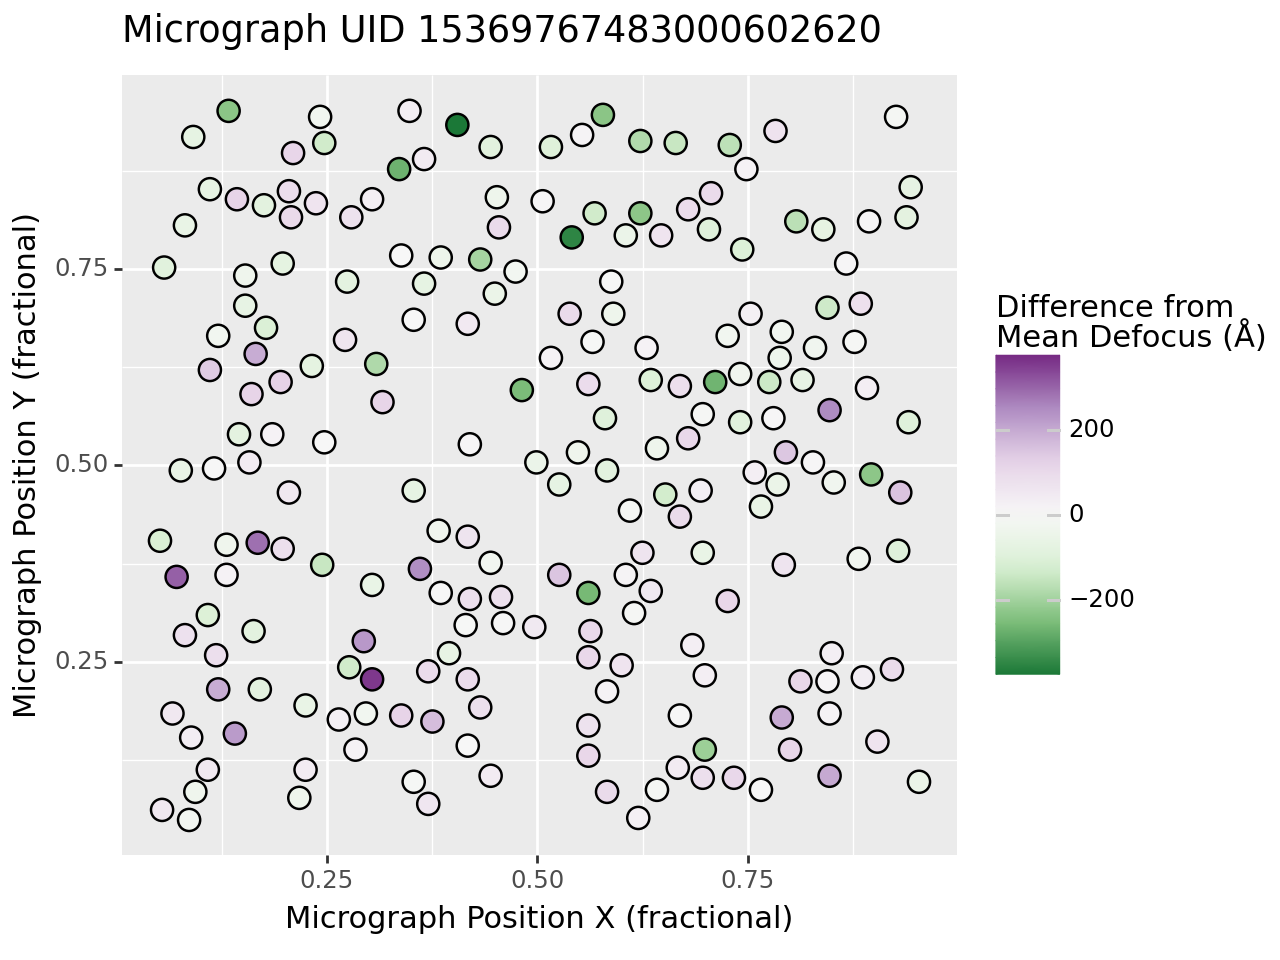

<Figure Size: (640 x 480)>

In [52]:
plot_single_mic(0)

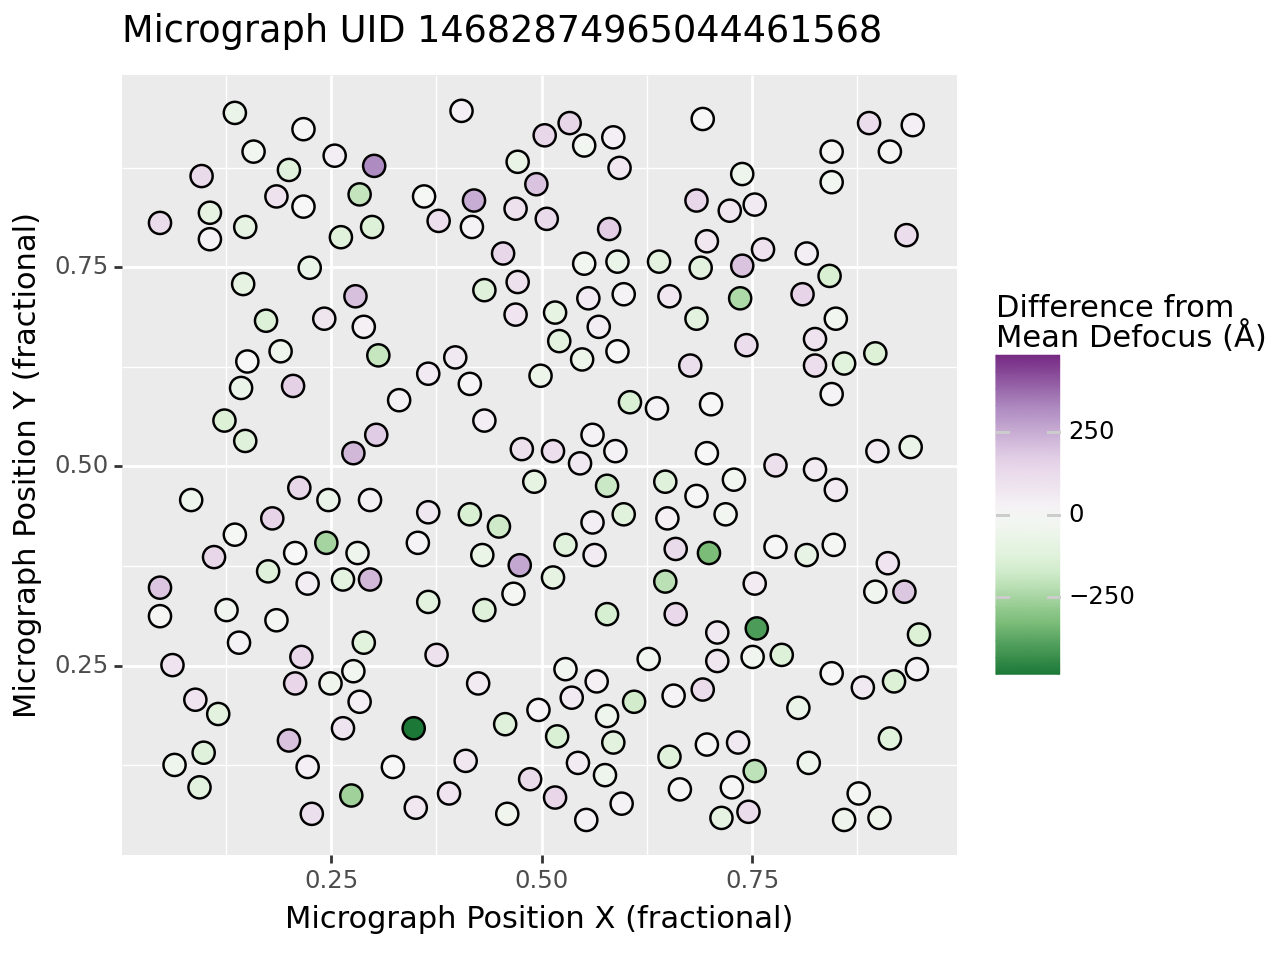

<Figure Size: (640 x 480)>

In [53]:
plot_single_mic(1)

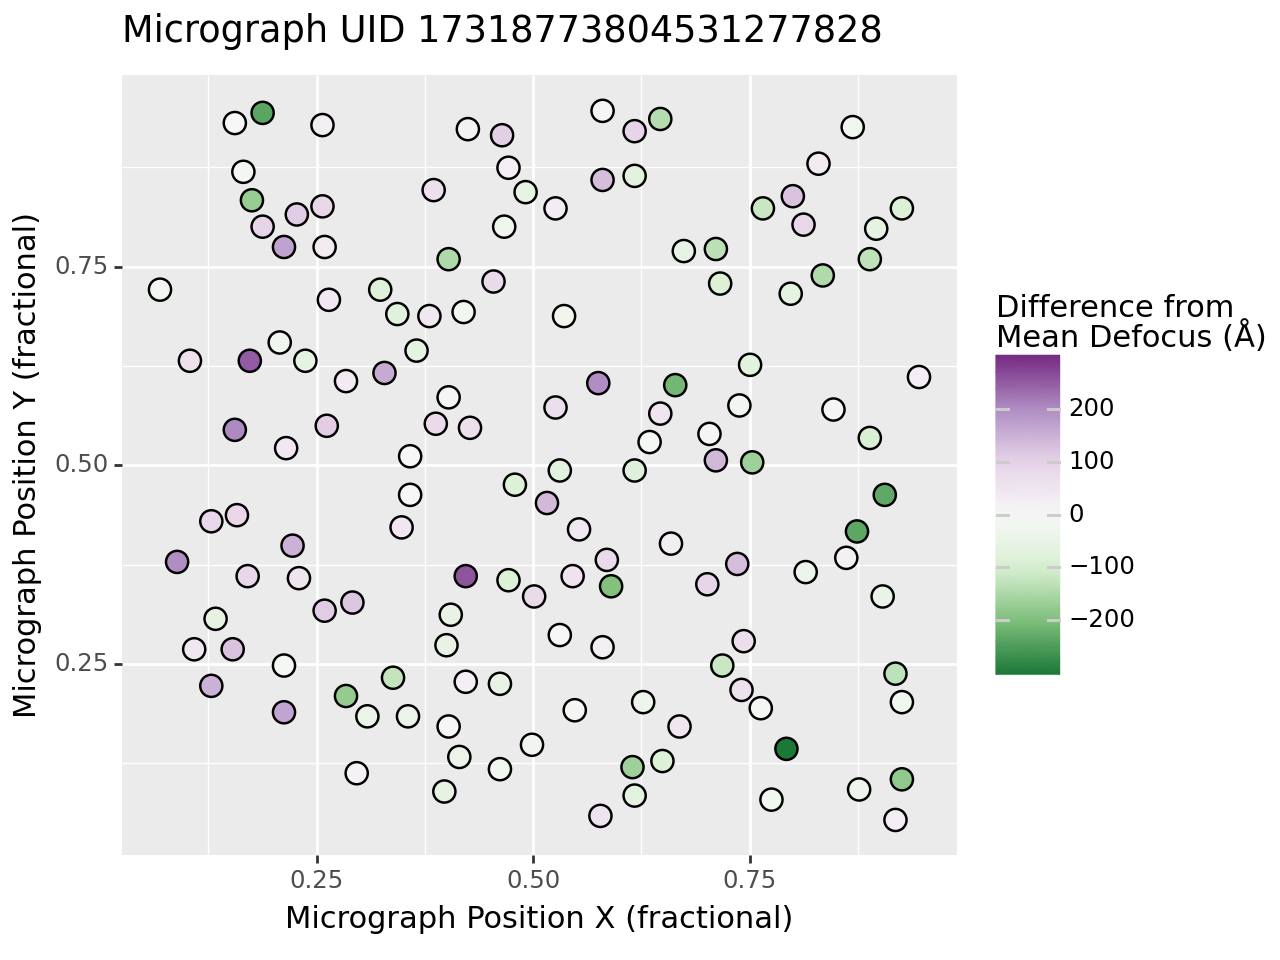

<Figure Size: (640 x 480)>

In [54]:
plot_single_mic(2)